# Summary before 11.17

In [1]:
import IPython.display
from ipywidgets import interact, interactive, fixed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import copy
from scipy.fftpack import fft
from scipy import ifft
from scipy.signal import butter, lfilter
import scipy.ndimage
import soundfile as sf
from scipy import ceil, complex64, float64, hamming, zeros

In [2]:
def read_Flac(filename):
    data, fs = \
        sf.read('/Users/admin/Desktop/practiceunderpycharm/flac_dataforcnn/' + str(filename) + '.flac')
    return data, fs

In [3]:
### Parameters part ###
data, fs = read_Flac(11290)
data = data[:16000 * 3]
fftLen = 512
win = hamming(fftLen)
step = int(fftLen / 4)

In [4]:
def stft(x, win, step):
    l = len(x)  # length of data
    N = len(win)  # length of window
    M = int(ceil(float(l - N + step) / step))  # Number of Windows in the spectrogram

    new_x = zeros(N + ((M - 1) * step), dtype=float64)
    new_x[: l] = x

    X = zeros([M, N], dtype=complex64)  # Initialization of spectrogram (complex type)
    for m in range(M):
        start = step * m
        X[m, :] = fft(new_x[start: start + N] * win)
    return X


In [5]:
def istft(spectrogram, win, step):
    M, N = spectrogram.shape
    assert (len(win) == N), "FFT length and window length are different."

    l = (M - 1) * step + N
    x = zeros(l, dtype=float64)
    wsum = zeros(l, dtype=float64)
    for m in range(M):
        start = step * m
        ### Smooth connection
        x[start: start + N] = x[start: start + N] + ifft(spectrogram[m, :]).real * win
        wsum[start: start + N] += win ** 2
    pos = (wsum != 0)
    x_pre = x.copy()
    ### Scaling windows
    x[pos] /= wsum[pos]
    return x

In [6]:
spectrogram_1 = stft(data,win,step)

In [7]:
print('Original signal')
IPython.display.Audio(data=data, rate=fs)

Original signal


In [8]:
reversed_signal = istft(spectrogram_1,win,step)

In [9]:
print('Reversed signal')
IPython.display.Audio(data=reversed_signal, rate=fs)

Reversed signal


#### This reversed signal is almost 100% right
#### Let see what will happen is we use a mask 

In [10]:
s = spectrogram_1
# The theshold value can be acted on the abs(spectrogram) or np.real(spectrogram), both seems alright?
# The important thing is How to choose the value to generate mask
# eg, '2' seems too big for this one
# '1' seems alright
s = np.where(abs(s) > 1, s, 0) 
s = np.where(abs(s) < 1, s, 1)
s = np.real(s)

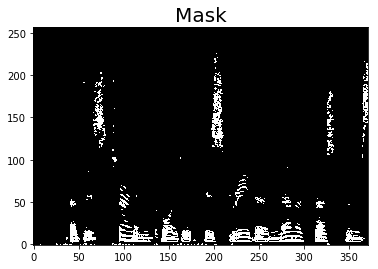

In [11]:
plt.imshow(abs(s[:, : int(fftLen / 2 + 1)].T), aspect = "auto", cmap=plt.cm.afmhot, origin = "lower")
plt.title("Mask", fontsize = 20)
plt.show()


In [12]:
masked_signal =  np.logical_and(spectrogram_1,s)*spectrogram_1

In [13]:
reversed_masked_signal = istft(masked_signal,win,step)

In [14]:
print('Reversed masked signal')
IPython.display.Audio(data=reversed_masked_signal, rate=fs)

Reversed masked signal


 #### Use 'np.logical_and' with the mask to get useful information inside the spectrogram.
 #### The thing is, the bigger the mask is, ofcourse more clear the reversed sound will be,  but also more difficult to trian. As if we use theshold value as 1, will make the mask too big.

In [15]:

noise_power = np.var(data) * 5
noise = np.random.normal(scale=noise_power, size=data.shape)

# define a function to mix
# def mix_with_noise(data, noise):
#     mix = data + noise
#     return mix

data = data + noise


In [16]:
spectrogram_2 = stft(data,win,step)

In [17]:
print('Original signal plus noise')
IPython.display.Audio(data=data, rate=fs)

Original signal plus noise


In [18]:
reversed2_signal = istft(spectrogram_2,win,step)
print('Reversed noised signal')
IPython.display.Audio(data=reversed2_signal, rate=fs)

Reversed noised signal


#### Now let's see if we use mask, what will happen

In [19]:
s = spectrogram_2
ph = np.phase(s)
s = np.where(abs(s) > 0.5, s, 0)
s = np.where(abs(s) < 0.5, s, 1)
s = np.real(s)

masked_signal =  np.logical_and(spectrogram_2,s)*abs(spectrogram_2)*exp(1j*ph) 

reversed_masked_signal2 = istft(masked_signal,win,step)

print('Reversed masked signal')
IPython.display.Audio(data=reversed_masked_signal2, rate=fs)

AttributeError: module 'numpy' has no attribute 'phase'

In [ ]:
plt.imshow(abs(s[:, : int(fftLen / 2 + 1)].T), aspect = "auto", cmap=plt.cm.afmhot, origin = "lower")
plt.title("Mask", fontsize = 20)
plt.show()

### The results above show that if choose the right value of threshold for mask. Surprisely, the mask even separated noise very good.

In [ ]:
s = spectrogram_2
s = np.where(abs(np.real(s)) > 1, s, 0)
s = np.where(abs(np.real(s)) < 1, s, 1)
s = np.real(s)

masked_signal =  np.logical_and(spectrogram_2,s)*np.real(spectrogram_2) + np.imag(spectrogram_2)

reversed_masked_signal2 = istft(masked_signal,win,step)

print('Reversed masked signal')
IPython.display.Audio(data=reversed_masked_signal2, rate=fs)

## However, with more noise been filtered by higher magnitude of threshold, the voice also been impaired/weaken.